# ⚡ Training Workflow (1–14)
이 구간은 빠르게 데이터 일부로 end-to-end 학습과 검증을 수행하는 스모크 테스트 플로우입니다. 아래 순서대로 각 셀을 실행하세요.

# 1. Import required libraries


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import sys, math, json, random, contextlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch_geometric.datasets import AirfRANS
from torch_geometric.data import Data, Batch
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch_geometric.data import Data
from navier_stokes_physics_loss import NavierStokesPhysicsLoss
from airfrans_utils import prepare_airfrans_graph_for_physics, estimate_node_area, build_bc_masks_airfrans
import contextlib
import wandb  
from torch.cuda.amp import GradScaler, autocast

def get_lr(optim):
    return optim.param_groups[0].get('lr', None)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
print('SmokeTest | PyTorch:', torch.__version__, '| CUDA?', torch.cuda.is_available())

SmokeTest | PyTorch: 2.8.0+cu128 | CUDA? True


# 2. Set Configuration

In [2]:
# 2) Configuration (minimal for smoke)
from dataclasses import dataclass, asdict

@dataclass
class SmokeCfg:
    seed: int = 42
    task: str = 'scarce'
    root: str = 'Dataset'
    # subsample graph count for smoke
    limit_train: int = 180
    limit_val: int = 20

    # training
    batch_size: int = 2
    epochs: int = 100
    hidden: int = 128
    layers: int = 7
    lr: float = 4e-4
    weight_decay: float = 1e-2  # typical AdamW wd
    betas: tuple[float, float] = (0.9, 0.95)
    eps: float = 1e-8
    amp: bool = False

    # lr scheduler: 'cosine', 'cosine_warm_restarts', 'reduce_on_plateau', or None
    lr_scheduler: str = 'cosine'
    # cosine params
    cosine_T_max: int = 80  # epochs
    cosine_eta_min: float = 1e-6
    # warm restarts params
    wr_T_0: int = 10
    wr_T_mult: int = 1
    wr_eta_min: float = 1e-6
    # reduce on plateau params
    rop_factor: float = 0.5
    rop_patience: int = 5
    rop_min_lr: float = 1e-6

    # Physics-Informed Loss Configuration
    # =====================================
    # Curriculum learning schedule
    ramp_start_epoch: int = 30              # Epoch to start ramping physics losses
    ramp_epochs: int = 80                   # Number of epochs to ramp up
    ramp_mode: str = 'linear'               # 'linear' or 'cosine'
    
    # MSE/Data loss
    data_loss_weight: float = 1.0           # Weight for MSE loss (constant)
    
    # Continuity equation loss
    continuity_loss_weight: float = 0.05    # Initial continuity weight
    continuity_target_weight: float = 0.10  # Target continuity weight after ramp
    
    # Momentum equation loss  
    momentum_loss_weight: float = 0.05      # Initial momentum weight
    momentum_target_weight: float = 0.10    # Target momentum weight after ramp
    
    # Boundary condition loss
    bc_loss_weight: float = 0.05            # Weight for boundary condition loss
    
    # Physics parameters
    chord_length: float = 1.0               # Airfoil chord length
    nu_molecular: float = 1.5e-5            # Molecular viscosity
    dynamic_uref_from_data: bool = True     # Compute reference velocity from data
    dynamic_re_from_data: bool = True       # Compute Reynolds number from data
    uinf_from: str = 'inlet'                # 'inlet', 'farfield', or 'robust'
    
    # Stability & outlier control
    use_huber_for_physics: bool = True      # Use Huber loss for physics terms
    huber_delta: float = 0.05               # Huber loss delta parameter
    use_perimeter_norm_for_div: bool = True # Normalize divergence by perimeter
    div_area_floor_factor: float = 0.25     # Area floor factor for stability
    div_min_degree: int = 2                 # Minimum node degree for physics loss
    
    # Debug & monitoring
    physics_debug: bool = False              # Enable physics loss debugging
    physics_debug_level: int = 1            # Debug verbosity (1=summary, 2=detailed)
    physics_debug_every: int = 50           # Log debug info every N steps

    # Global Context & Attention Configuration
    use_global_tokens: bool = True           # Enable/disable global tokens
    num_global_tokens: int = 4               # Number of global tokens
    attention_heads: int = 4                 # Multi-head attention heads
    attention_layers: int = 7               # Number of transformer layers
    attention_dropout: float = 0.0           # Attention dropout rate
    use_cross_attention: bool = True         # Cross-attention between local and global
    global_pooling_type: str = 'attention'   # 'mean', 'max', 'attention', 'set2set'
    positional_encoding: bool = True         # Use positional encoding
    pos_encoding_max_len: int = 50000        # Max sequence length for positional encoding
    # Advanced attention options
    use_residual_attention: bool = True      # Residual connections in attention
    attention_normalization: str = 'layer'   # 'layer', 'batch', 'rms'
    temperature_scaling: bool = True         # Temperature scaling for attention
    attention_bias: bool = False             # Use bias in attention projections

    # W&B Artifact 관리
    use_wandb_artifacts: bool = False        # W&B artifact 사용 여부
    artifact_save_best_only: bool = True     # best 모델만 업로드
    artifact_save_interval: int = 50         # periodic 저장 간격 (epochs)
    
    # Checkpoint 관리
    ckpt_dir: str = "checkpoints"           # 로컬 체크포인트 디렉토리
    ckpt_interval: int = 5                  # 로컬 체크포인트 저장 간격
    
    # W&B 설정
    wandb_project: str = "airfrans-gnn"
    wandb_mode: str = "online"              # "online", "offline", "disabled"
    log_every_n_steps: int = -1             # 로깅 빈도
    log_epoch_only: bool = True             # Epoch 로깅만 사용

scfg = SmokeCfg()
set_seed(scfg.seed)
print('Smoke config:', asdict(scfg))

Smoke config: {'seed': 42, 'task': 'scarce', 'root': 'Dataset', 'limit_train': 180, 'limit_val': 20, 'batch_size': 2, 'epochs': 100, 'hidden': 128, 'layers': 7, 'lr': 0.0004, 'weight_decay': 0.01, 'betas': (0.9, 0.95), 'eps': 1e-08, 'amp': False, 'lr_scheduler': 'cosine', 'cosine_T_max': 80, 'cosine_eta_min': 1e-06, 'wr_T_0': 10, 'wr_T_mult': 1, 'wr_eta_min': 1e-06, 'rop_factor': 0.5, 'rop_patience': 5, 'rop_min_lr': 1e-06, 'ramp_start_epoch': 30, 'ramp_epochs': 80, 'ramp_mode': 'linear', 'data_loss_weight': 1.0, 'continuity_loss_weight': 0.05, 'continuity_target_weight': 0.1, 'momentum_loss_weight': 0.05, 'momentum_target_weight': 0.1, 'bc_loss_weight': 0.05, 'chord_length': 1.0, 'nu_molecular': 1.5e-05, 'dynamic_uref_from_data': True, 'dynamic_re_from_data': True, 'uinf_from': 'inlet', 'use_huber_for_physics': True, 'huber_delta': 0.05, 'use_perimeter_norm_for_div': True, 'div_area_floor_factor': 0.25, 'div_min_degree': 2, 'physics_debug': False, 'physics_debug_level': 1, 'physics_de

# 3. Load dataset indices

In [3]:
from torch_geometric.transforms import BaseTransform

class _PreparePhysics(BaseTransform):
    def __call__(self, data):
        # edge_attr_dxdy가 이미 있을 경우 build_edge_attr_dxdy는 생략되고 나머지만 수행
        return prepare_airfrans_graph_for_physics(data, verbose=False)

# 3) Load dataset indices (train/val split)
assert os.path.isdir(scfg.root), f"Dataset folder not found: {scfg.root}"
try:
    ds_train = AirfRANS(root=scfg.root, train=True, task=scfg.task, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, task=scfg.task, transform=_PreparePhysics())
except TypeError:
    ds_train = AirfRANS(root=scfg.root, train=True, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, transform=_PreparePhysics())

if scfg.task == 'scarce':
    # Scarce provides train only; create 90/10 split from ds_train
    n = len(ds_train)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n]
    # limit if requested
    if scfg.limit_train > 0:
        ids_train = ids_train[:scfg.limit_train + scfg.limit_val]
        
    train_raw = Subset(ds_train, ids_train)
    val_raw = None
    
else:
    ids_train = list(range(min(scfg.limit_train+scfg.limit_val, len(ds_train))))
    ids_val = ids_train[-scfg.limit_val:] if scfg.limit_val>0 else []
    ids_train = ids_train[:scfg.limit_train] if scfg.limit_train>0 else ids_train
    train_raw = Subset(ds_train, ids_train)
    val_raw   = Subset(ds_train, ids_val) if ids_val else []

print('Loaded subset indices:', len(train_raw), 'train |', len(val_raw) if isinstance(val_raw, Subset) else 0, 'val/test')

Loaded subset indices: 200 train | 0 val/test


# 4. Load prebuilt graphs and ensure features (index-aligned with raw)

In [4]:
# 6) Load prebuilt graphs and ensure features (index-aligned with raw)
import glob, os, re
from utils import with_pos2, prep_graph, validate_edges, _prep_graph_for_norm

USE_PREBUILT = True
PREBUILT_ROOT = 'prebuilt_edges/scarce'  # change to your path if different
PREBUILT_TRAIN_DIR = f"{PREBUILT_ROOT}/train"
PREBUILT_TEST_DIR  = f"{PREBUILT_ROOT}/test"
DOWNSAMPLED_ROOT = 'downsampled_graphs/scarce'

# Load prebuilt edge graphs
train_edge_files = sorted(glob.glob(os.path.join(PREBUILT_TRAIN_DIR, 'graph_*.pt')))
val_edge_files   = sorted(glob.glob(os.path.join(PREBUILT_TEST_DIR,  'graph_*.pt')))
print(f"[prebuilt] found: {len(train_edge_files)} train and {len(val_edge_files)} val graphs under {PREBUILT_ROOT}")

# Load tensors and prepare
train_edges = []
for p in train_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    train_edges.append(prep_graph(d))

val_edges = []
for p in val_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    val_edges.append(prep_graph(d))

print(f"Graphs prepared. Example dims -> x: {train_edges[0].x.shape if len(train_edges)>0 else None}  edge_attr: {train_edges[0].edge_attr.shape if (len(train_edges)>0 and hasattr(train_edges[0],'edge_attr') and train_edges[0].edge_attr is not None) else None}")

validate_edges(train_edges, 'train_edges')

[prebuilt] found: 200 train and 0 val graphs under prebuilt_edges/scarce
Graphs prepared. Example dims -> x: torch.Size([16124, 5])  edge_attr: torch.Size([95510, 5])
[validate] train_edges: total=200 bad=0


# 5. Nnormalized datasets


In [5]:
if scfg.task == 'scarce':
    n = len(train_edges)
    n_train = int(n * 0.9)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n_train]
    ids_val = ids_all[n_train:]

    # Use prebuilt graphs, not raw dataset
    train_edges_subset = [train_edges[i] for i in ids_train]
    val_edges_subset = [train_edges[i] for i in ids_val] if ids_val else []
else:
    train_edges_subset = train_edges
    val_edges_subset = val_edges

train_prepped = [_prep_graph_for_norm(g) for g in train_edges_subset]
val_prepped   = [_prep_graph_for_norm(g) for g in val_edges_subset] if isinstance(val_edges_subset, list) else []

# 8b) Fit scalers on train_prepped
if 'StandardScaler' not in globals():
    class StandardScaler:
        def __init__(self):
            self.mean = None
            self.std = None
        def fit(self, t: torch.Tensor):
            self.mean = t.mean(dim=0)
            self.std = t.std(dim=0).clamp_min(1e-8)
            return self
        def transform(self, t: torch.Tensor):
            return (t - self.mean) / self.std
        def inverse(self, t: torch.Tensor):
            return t * self.std + self.mean

# Concatenate node features/targets across train graphs for fitting
X_train = torch.cat([d.x for d in train_prepped if hasattr(d, 'x') and d.x is not None], dim=0)
Y_train = torch.cat([d.y for d in train_prepped if hasattr(d, 'y') and d.y is not None], dim=0)

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Y_train)

# 8c) Build normalized dataset wrappers
class NormalizedDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, x_scaler, y_scaler):
        self.graphs = graphs
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        
    def __len__(self):
        return len(self.graphs)
        
    def __getitem__(self, idx: int):
        d = self.graphs[idx]
        dm = Data(**{k: v for k, v in d})
        dm.x = self.x_scaler.transform(d.x)
        if hasattr(d, 'y') and d.y is not None:
            dm.y = self.y_scaler.transform(d.y)
        else:
            dm.y = d.y
            
        # DON'T attach norm params as graph attributes - they cause batching issues
        # Instead, we'll handle denormalization differently
        # dm.x_norm_params = {'mean': self.x_scaler.mean.clone(), 'scale': self.x_scaler.std.clone()}
        # dm.y_norm_params = {'mean': self.y_scaler.mean.clone(), 'scale': self.y_scaler.std.clone()} if dm.y is not None else None
        
        # Store scalers as module-level attributes for physics loss to access
        dm.has_norm = True  # Flag to indicate normalized data
        
        # Ensure edge_attr_dxdy is present (needed for physics loss)
        if hasattr(d, 'edge_attr_dxdy'):
            dm.edge_attr_dxdy = d.edge_attr_dxdy
        elif hasattr(d, 'edge_attr'):
            # If we have edge_attr but not edge_attr_dxdy, use the last 2 dims as dxdy
            if d.edge_attr.shape[1] >= 2:
                dm.edge_attr_dxdy = d.edge_attr[:, -2:]  # Last 2 columns should be dx, dy
            dm.edge_attr = d.edge_attr
        
        # Build BC masks properly
        from airfrans_utils import build_bc_masks_airfrans
        dm = build_bc_masks_airfrans(dm)
        
        # Ensure individual BC masks are present as attributes
        if hasattr(dm, 'bc_mask_dict'):
            for bc_type, mask in dm.bc_mask_dict.items():
                setattr(dm, f'is_{bc_type}', mask)
        else:
            # Fallback: create default masks if build_bc_masks_airfrans failed
            num_nodes = dm.x.size(0)
            # Use the normalized x for BC detection
            x_orig = d.x  # Use original (non-normalized) for BC detection
            
            # Wall nodes: distance_wall < threshold (column 2 of original x)
            if x_orig.size(1) > 2:
                wall_dist = x_orig[:, 2]
                dm.is_wall = (wall_dist < 1e-6)
            else:
                dm.is_wall = torch.zeros(num_nodes, dtype=torch.bool)
            
            # For AirfRANS, we typically don't have explicit inlet/outlet/farfield in the features
            # These would need to be inferred from position or other criteria
            dm.is_inlet = torch.zeros(num_nodes, dtype=torch.bool)
            dm.is_outlet = torch.zeros(num_nodes, dtype=torch.bool)
            dm.is_farfield = torch.zeros(num_nodes, dtype=torch.bool)
            
            # Simple heuristics for inlet/outlet/farfield based on position
            if hasattr(dm, 'pos'):
                x_coords = dm.pos[:, 0]
                y_coords = dm.pos[:, 1]
                
                # Inlet: leftmost boundary (x < -1)
                dm.is_inlet = (x_coords < -1.0) & ~dm.is_wall
                
                # Outlet: rightmost boundary (x > 2)
                dm.is_outlet = (x_coords > 2.0) & ~dm.is_wall
                
                # Farfield: top/bottom boundaries (|y| > 1)
                dm.is_farfield = (torch.abs(y_coords) > 1.0) & ~dm.is_wall & ~dm.is_inlet & ~dm.is_outlet
        
        return dm

train_norm = NormalizedDataset(train_prepped, x_scaler, y_scaler)
val_norm   = NormalizedDataset(val_prepped, x_scaler, y_scaler) if isinstance(val_prepped, list) and len(val_prepped) > 0 else []

# Debug BC mask creation for a single sample
test_single = train_norm[0]
print("Single sample BC check:")
print(f"  Total nodes: {test_single.x.size(0)}")

# Check original features that determine BC
if hasattr(test_single, 'x'):
    x_orig = train_prepped[0].x  # Original unnormalized
    print(f"  Original x shape: {x_orig.shape}")
    if x_orig.size(1) > 2:
        wall_dist = x_orig[:, 2]
        print(f"  Wall distance range: [{wall_dist.min():.3e}, {wall_dist.max():.3e}]")
        print(f"  Nodes with wall_dist < 1e-6: {(wall_dist < 1e-6).sum().item()}")

# Check the BC masks
for bc_type in ['wall', 'inlet', 'outlet', 'farfield']:
    mask_name = f'is_{bc_type}'
    if hasattr(test_single, mask_name):
        mask = getattr(test_single, mask_name)
        print(f"  {mask_name}: {mask.sum().item()} nodes ({mask.sum().item()/len(mask)*100:.1f}%)")

# Check position-based criteria if available
if hasattr(test_single, 'pos'):
    pos = test_single.pos
    print(f"\n  Position ranges:")
    print(f"    x: [{pos[:, 0].min():.2f}, {pos[:, 0].max():.2f}]")
    print(f"    y: [{pos[:, 1].min():.2f}, {pos[:, 1].max():.2f}]")



print('Prepared normalized datasets:', len(train_norm), 'train |', (len(val_norm) if isinstance(val_norm, NormalizedDataset) else len(val_norm)), 'val')
if len(train_prepped) > 0:
    print('Example dims -> x:', tuple(train_prepped[0].x.shape), '| edge_attr:', (tuple(train_prepped[0].edge_attr.shape) if hasattr(train_prepped[0], 'edge_attr') and train_prepped[0].edge_attr is not None else None))


Single sample BC check:
  Total nodes: 16059
  Original x shape: torch.Size([16059, 7])
  Wall distance range: [0.000e+00, 3.563e+00]
  Nodes with wall_dist < 1e-6: 1026
  is_wall: 1026 nodes (6.4%)
  is_inlet: 1645 nodes (10.2%)
  is_outlet: 1833 nodes (11.4%)
  is_farfield: 2289 nodes (14.3%)

  Position ranges:
    x: [-2.16, 4.23]
    y: [-1.63, 1.62]
Prepared normalized datasets: 180 train | 20 val
Example dims -> x: (16059, 7) | edge_attr: (94686, 5)


In [6]:
data = train_norm[0]

row, col = data.edge_index
deg = torch.bincount(row, minlength=data.num_nodes) + torch.bincount(col, minlength=data.num_nodes)
print("deg==0:", int((deg==0).sum()), " / ", data.num_nodes)
print("deg<2 :", int((deg<2).sum()))


deg==0: 88  /  16059
deg<2 : 88


# 6. DataLoaders


In [7]:
# Use true batching with PyG Batch.from_data_list so batch_size>1 works correctly

def collate_pyg(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return Batch.from_data_list(batch)

train_loader = DataLoader(train_norm, batch_size=scfg.batch_size, shuffle=True, num_workers=0, collate_fn=collate_pyg)
val_loader   = DataLoader(val_norm,   batch_size=scfg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_pyg) if isinstance(val_norm, NormalizedDataset) else []
print('Loaders ready:', len(train_norm), 'train samples | batch_size =', scfg.batch_size)
print('Loaders ready:', len(val_norm), 'val samples | batch_size =', scfg.batch_size)

Loaders ready: 180 train samples | batch_size = 2
Loaders ready: 20 val samples | batch_size = 2


# 7. Train/Val epoch routines

In [8]:
# 13) Enhanced Train/Val epoch routines with Physics Loss

mse_loss_fn = nn.MSELoss()

def compute_loss_with_physics(predictions, targets, data, loss_fn=None, *, step: int | None = None):
    """Compute loss using physics-informed loss function or fallback to MSE
    Returns a differentiable scalar loss tensor for backward as first value,
    and a lightweight dict of float metrics for logging as second value.
    """
    if loss_fn is not None:
        try:
            # Always let the physics loss handle batched Data (PyG batches are a big disjoint graph)
            loss_dict = loss_fn(predictions, targets, data=data, step=step)

            # Ensure total_loss is a Tensor usable for backward
            total_loss = loss_dict.get('total_loss')
            if not isinstance(total_loss, torch.Tensor):
                total_loss = torch.as_tensor(total_loss, dtype=predictions.dtype, device=predictions.device)

            # Prepare a logging-friendly dict (floats only) to avoid holding graph refs
            log_dict = {}
            for k, v in loss_dict.items():
                if isinstance(v, torch.Tensor):
                    try:
                        log_dict[k] = float(v.detach().item())
                    except Exception:
                        # Fallback if it's not 0-dim
                        log_dict[k] = float(v.detach().mean().item())
                else:
                    log_dict[k] = float(v)

            return total_loss, log_dict
        except Exception as e:
            print(f"Warning: Physics loss failed ({e}), falling back to MSE")
            mse_loss = mse_loss_fn(predictions, targets)
            return mse_loss, {
                'mse_loss': float(mse_loss.detach().item()), 
                'continuity_loss': 0.0, 
                'momentum_loss': 0.0,
                'bc_loss': 0.0,  # ← BC loss 추가
                'total_loss': float(mse_loss.detach().item())
            }
    else:
        # Fallback to simple MSE
        mse_loss = mse_loss_fn(predictions, targets)
        return mse_loss, {
            'mse_loss': float(mse_loss.detach().item()), 
            'bc_loss': 0.0,  # ← BC loss 추가
            'total_loss': float(mse_loss.detach().item())
        }


@torch.no_grad()
def run_epoch(loader, model, device, scaler=None, desc: str = 'val', loss_fn=None):
    model.eval()
    total_losses = []; mse_losses = []; continuity_losses = []; momentum_losses = []
    bc_losses = []  # ← BC loss 리스트 추가
    cont_w_used_hist, mom_w_used_hist = [], []

    if loader is None or (isinstance(loader, list) and len(loader)==0):
        return float('nan'), {}

    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)

    for batch in loader:
        try:
            if batch is None:
                pbar.update(1); continue

            b = batch.to(device)
            with (autocast(enabled=(scfg.amp and torch.cuda.is_available()))
                  if torch.cuda.is_available() else contextlib.nullcontext()):
                out = model(b)
                _, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=None)

            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))
            bc_losses.append(loss_dict.get('bc_loss', 0.0))  # ← BC loss 수집
            if 'cont_weight_used' in loss_dict: cont_w_used_hist.append(loss_dict['cont_weight_used'])
            if 'mom_weight_used'  in loss_dict: mom_w_used_hist.append(loss_dict['mom_weight_used'])

            postfix = {"total": f"{loss_dict['total_loss']:.4e}"}
            if 'continuity_loss' in loss_dict: postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"
            if 'momentum_loss' in loss_dict:   postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"
            if 'bc_loss' in loss_dict:         postfix["bc"] = f"{loss_dict['bc_loss']:.4e}"  # ← BC loss 표시
            pbar.set_postfix(postfix)

        finally:
            pbar.update(1)

    pbar.close()

    avg_losses = {
        'total_loss': np.mean(total_losses) if total_losses else float('nan'),
        'mse_loss': np.mean(mse_losses) if mse_losses else float('nan'),
        'continuity_loss': np.mean(continuity_losses) if continuity_losses else float('nan'),
        'momentum_loss': np.mean(momentum_losses) if momentum_losses else float('nan'),
        'bc_loss': np.mean(bc_losses) if bc_losses else float('nan'),  # ← BC loss 평균
    }
    if cont_w_used_hist: avg_losses['cont_weight_used'] = float(np.mean(cont_w_used_hist))
    if mom_w_used_hist:  avg_losses['mom_weight_used']  = float(np.mean(mom_w_used_hist))
    return avg_losses['total_loss'], avg_losses



def train_epoch(loader, model, optim, device, scaler, desc: str = 'train',
                loss_fn=None, global_step_start: int = 0, scheduler=None, scheduler_step_mode: str = "epoch",
                log_every_n_steps: int = -1):  # -1로 설정하면 step 로깅 비활성화
    model.train()
    total_losses, mse_losses, continuity_losses, momentum_losses = [], [], [], []
    bc_losses = []
    cont_w_used_hist, mom_w_used_hist = [], []

    global_step = global_step_start
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)

    for batch_idx, batch in enumerate(loader):
        try:
            if batch is None:
                pbar.update(1); global_step += 1; continue

            b = batch.to(device)
            optim.zero_grad(set_to_none=True)

            use_scaler = (scaler is not None) and getattr(scaler, "is_enabled", lambda: False)()

            if use_scaler:
                with autocast(enabled=torch.cuda.is_available()):
                    out = model(b)
                    loss, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=global_step)
                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optim)
                scaler.update()
            else:
                with contextlib.nullcontext():
                    out = model(b)
                    loss, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=global_step)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optim.step()

            if scheduler is not None and scheduler_step_mode == "step":
                try:
                    scheduler.step()
                except TypeError:
                    pass

            # 집계
            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))
            bc_losses.append(loss_dict.get('bc_loss', 0.0))
            if 'cont_weight_used' in loss_dict: cont_w_used_hist.append(loss_dict['cont_weight_used'])
            if 'mom_weight_used'  in loss_dict: mom_w_used_hist.append(loss_dict['mom_weight_used'])

            # === Step-level 로깅 완전 제거 또는 조건부 비활성화 ===
            if log_every_n_steps > 0 and (batch_idx % max(1, log_every_n_steps)) == 0:
                # Step-level 로깅을 원하는 경우에만 실행
                log_payload = {
                    "step": global_step,
                    "train/total": loss_dict['total_loss'],
                    "train/mse": loss_dict['mse_loss'],
                    "train/continuity": loss_dict.get('continuity_loss', 0.0),
                    "train/momentum": loss_dict.get('momentum_loss', 0.0),
                    "train/bc": loss_dict.get('bc_loss', 0.0),
                }
                if 'cont_weight_used' in loss_dict: log_payload["weight/cont_used"] = loss_dict['cont_weight_used']
                if 'mom_weight_used'  in loss_dict: log_payload["weight/mom_used"]  = loss_dict['mom_weight_used']
                lr_now = get_lr(optim)
                if lr_now is not None:
                    log_payload["lr"] = lr_now
                wandb.log(log_payload, step=global_step, commit=False)

            postfix = {"total": f"{loss_dict['total_loss']:.4e}",
                       "lr": f"{get_lr(optim):.2e}" if get_lr(optim) is not None else "n/a"}
            if 'continuity_loss' in loss_dict: postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"
            if 'momentum_loss' in loss_dict:   postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"
            if 'bc_loss' in loss_dict:         postfix["bc"] = f"{loss_dict['bc_loss']:.4e}"
            pbar.set_postfix(postfix)

        finally:
            pbar.update(1)
            global_step += 1

    pbar.close()

    avg_losses = {
        'total_loss': np.mean(total_losses) if total_losses else float('nan'),
        'mse_loss': np.mean(mse_losses) if mse_losses else float('nan'),
        'continuity_loss': np.mean(continuity_losses) if continuity_losses else float('nan'),
        'momentum_loss': np.mean(momentum_losses) if momentum_losses else float('nan'),
        'bc_loss': np.mean(bc_losses) if bc_losses else float('nan'),
    }
    if cont_w_used_hist: avg_losses['cont_weight_used'] = float(np.mean(cont_w_used_hist))
    if mom_w_used_hist:  avg_losses['mom_weight_used']  = float(np.mean(mom_w_used_hist))

    return avg_losses['total_loss'], avg_losses, global_step

# Loss Definition

Continuity equation을 활용한 physics loss를 training과 validation에 통합합니다.

In [9]:
# Import and setup physics-informed loss
from importlib import reload
from typing import Dict, Optional
from navier_stokes_physics_loss import NavierStokesPhysicsLoss

steps_per_epoch = len(train_loader)

loss_fn = NavierStokesPhysicsLoss(
    # Data loss
    data_loss_weight=scfg.data_loss_weight,

    # Continuity loss with curriculum
    continuity_loss_weight=scfg.continuity_loss_weight,
    continuity_target_weight=scfg.continuity_target_weight,

    # Momentum loss with curriculum
    momentum_loss_weight=scfg.momentum_loss_weight,
    momentum_target_weight=scfg.momentum_target_weight,

    # Curriculum schedule
    curriculum_ramp_steps=scfg.ramp_epochs * steps_per_epoch,
    ramp_start_step=scfg.ramp_start_epoch * steps_per_epoch,
    cont_curriculum_ramp_steps=-1,  # Use shared schedule
    mom_curriculum_ramp_steps=-1,   # Use shared schedule
    ramp_mode=scfg.ramp_mode,

    # Boundary conditions
    bc_loss_weight=scfg.bc_loss_weight,
    chord_length=scfg.chord_length,
    
    # Physics parameters
    dynamic_uref_from_data=scfg.dynamic_uref_from_data,
    dynamic_re_from_data=scfg.dynamic_re_from_data,
    nu_molecular=scfg.nu_molecular,
    uinf_from=scfg.uinf_from,

    # Stability controls
    use_huber_for_physics=scfg.use_huber_for_physics,
    huber_delta=scfg.huber_delta,
    use_perimeter_norm_for_div=scfg.use_perimeter_norm_for_div,
    div_area_floor_factor=scfg.div_area_floor_factor,
    div_min_degree=scfg.div_min_degree,
    
    # Debug settings
    debug=scfg.physics_debug,
    debug_level=scfg.physics_debug_level,
    debug_every=scfg.physics_debug_every,
)

print(f"✅ Physics loss initialized:")
print(f"   Curriculum: start at epoch {scfg.ramp_start_epoch}, ramp for {scfg.ramp_epochs} epochs")
print(f"   Continuity: {scfg.continuity_loss_weight:.3f} → {scfg.continuity_target_weight:.3f}")
print(f"   Momentum: {scfg.momentum_loss_weight:.3f} → {scfg.momentum_target_weight:.3f}")
print(f"   BC weight: {scfg.bc_loss_weight:.3f} (constant)")
print(f"   ├─ Wall: No-slip condition (u=v=0)")
print(f"   ├─ Inlet: Prescribed velocity")
print(f"   ├─ Outlet: Zero-gradient")
print(f"   └─ Farfield: Freestream conditions")

✅ Physics loss initialized:
   Curriculum: start at epoch 30, ramp for 80 epochs
   Continuity: 0.050 → 0.100
   Momentum: 0.050 → 0.100
   BC weight: 0.050 (constant)
   ├─ Wall: No-slip condition (u=v=0)
   ├─ Inlet: Prescribed velocity
   ├─ Outlet: Zero-gradient
   └─ Farfield: Freestream conditions


In [10]:
# Add this test after the physics loss initialization

# Test batched data structure with BC masks
print("\n=== Testing Batched Data with BC Masks ===")
test_batch = next(iter(train_loader))
print(f"Batch info:")
print(f"  Batch size: {test_batch.num_graphs}")
print(f"  Total nodes: {test_batch.num_nodes}")
print(f"  Node features shape: {test_batch.x.shape}")
print(f"  Targets shape: {test_batch.y.shape}")

# Check BC masks
for bc_type in ['wall', 'inlet', 'outlet', 'farfield']:
    mask_name = f'is_{bc_type}'
    if hasattr(test_batch, mask_name):
        mask = getattr(test_batch, mask_name)
        print(f"  {mask_name} shape: {mask.shape}, sum: {mask.sum().item()}")
        # Check if the sum makes sense (should be roughly 2x individual graph values for batch_size=2)
        expected_range = (1000, 5000) if bc_type == 'wall' else (2000, 6000)
        if mask.sum().item() < 100:
            print(f"    ⚠️ WARNING: Very few {bc_type} nodes detected!")
    else:
        print(f"  {mask_name}: NOT FOUND")

# Check that masks are properly batched (not all True/False)
if hasattr(test_batch, 'is_wall'):
    wall_mask = test_batch.is_wall
    if wall_mask.all():
        print("\n❌ ERROR: All nodes marked as wall! BC masks not properly batched.")
    elif (~wall_mask).all():
        print("\n❌ ERROR: No wall nodes found! BC masks may be lost in batching.")
    else:
        print(f"\n✅ BC masks appear properly batched (wall: {wall_mask.sum().item()}/{len(wall_mask)} nodes)")

# Test physics loss with properly batched data
print("\n=== Testing Physics Loss ===")
test_predictions = torch.randn_like(test_batch.y).to(device)
test_batch = test_batch.to(device)
try:
    loss_dict = loss_fn(test_predictions, test_batch.y, test_batch, step=0)
    print(f"✅ Physics loss works with batch_size={test_batch.num_graphs}")
    for k, v in loss_dict.items():
        if 'loss' in k:
            print(f"   {k}: {v:.4e}")
except Exception as e:
    print(f"❌ Physics loss failed: {e}")
    import traceback
    traceback.print_exc()


=== Testing Batched Data with BC Masks ===
Batch info:
  Batch size: 2
  Total nodes: 32115
  Node features shape: torch.Size([32115, 7])
  Targets shape: torch.Size([32115, 4])
  is_wall shape: torch.Size([32115]), sum: 2027
  is_inlet shape: torch.Size([32115]), sum: 3262
  is_outlet shape: torch.Size([32115]), sum: 3729
  is_farfield shape: torch.Size([32115]), sum: 4609

✅ BC masks appear properly batched (wall: 2027/32115 nodes)

=== Testing Physics Loss ===
✅ Physics loss works with batch_size=2
   mse_loss: 1.5335e+00
   continuity_loss: 5.8582e-03
   momentum_loss: 2.2896e+05
   bc_loss: 1.8800e-01
   total_loss: 1.1449e+04


In [11]:
# Add this debug function to understand the issue better

def debug_physics_loss(batch_data, predictions, targets):
    """Debug helper to understand physics loss issues"""
    print("\n=== Physics Loss Debug ===")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Batch size: {batch_data.num_graphs if hasattr(batch_data, 'num_graphs') else 'N/A'}")
    print(f"Total nodes: {batch_data.num_nodes if hasattr(batch_data, 'num_nodes') else predictions.shape[0]}")
    
    # Check features
    if hasattr(batch_data, 'x'):
        print(f"Node features (x) shape: {batch_data.x.shape}")
    
    # Check edge attributes
    if hasattr(batch_data, 'edge_attr_dxdy'):
        print(f"edge_attr_dxdy shape: {batch_data.edge_attr_dxdy.shape}")
    elif hasattr(batch_data, 'edge_attr'):
        print(f"edge_attr shape: {batch_data.edge_attr.shape}")
    else:
        print("⚠️ No edge attributes found!")
    
    # Check BC masks
    for bc_type in ['wall', 'inlet', 'outlet', 'farfield']:
        mask_name = f'is_{bc_type}'
        if hasattr(batch_data, mask_name):
            mask = getattr(batch_data, mask_name)
            print(f"{mask_name}: shape={mask.shape}, sum={mask.sum().item()}, dtype={mask.dtype}")
    
    # Check if y_norm_params are present
    if hasattr(batch_data, 'y_norm_params'):
        print(f"y_norm_params present: {batch_data.y_norm_params.keys() if isinstance(batch_data.y_norm_params, dict) else 'Not a dict'}")
    
    # Try a simple MSE loss first
    try:
        simple_mse = F.mse_loss(predictions, targets)
        print(f"✅ Simple MSE loss works: {simple_mse:.4e}")
    except Exception as e:
        print(f"❌ Even simple MSE fails: {e}")
    
    return

# Test with debug
test_batch = next(iter(train_loader)).to(device)
test_pred = torch.randn_like(test_batch.y)
debug_physics_loss(test_batch, test_pred, test_batch.y)


=== Physics Loss Debug ===
Predictions shape: torch.Size([32131, 4])
Targets shape: torch.Size([32131, 4])
Batch size: 2
Total nodes: 32131
Node features (x) shape: torch.Size([32131, 7])
edge_attr_dxdy shape: torch.Size([191340, 3])
is_wall: shape=torch.Size([32131]), sum=2036, dtype=torch.bool
is_inlet: shape=torch.Size([32131]), sum=3266, dtype=torch.bool
is_outlet: shape=torch.Size([32131]), sum=3714, dtype=torch.bool
is_farfield: shape=torch.Size([32131]), sum=4598, dtype=torch.bool
✅ Simple MSE loss works: 1.3191e+00


# 8. Define Model


In [12]:
# Define model using EnhancedCFDModelWithGlobalContext (safe device placement)
from global_context_processor import EnhancedCFDModelWithGlobalContext
import torch
import gc

# Clean up memory before model instantiation
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    # Dimensions: utils._prep_graph_for_norm() appends pos2 -> node_dim = 7, edge_dim ensured = 5
    node_dim = 7
    edge_dim = 5

    # Set device: use CUDA if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Instantiate model with current smoke config (scfg)
    model = EnhancedCFDModelWithGlobalContext(
        node_feat_dim=node_dim,
        edge_feat_dim=edge_dim,
        hidden_dim=scfg.hidden,
        output_dim=4,
        num_mp_layers=scfg.layers,
        dropout_p=0.1,
        config=scfg  # pass explicitly to avoid module-scope dependency
    )

    # Move to target device
    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=scfg.lr,
        weight_decay=scfg.weight_decay,
        betas=scfg.betas,
        eps=scfg.eps,
    )

    print('🚀 Enhanced CFD Model with Global Context ready!')
    print(f'Configuration: global_tokens={scfg.use_global_tokens}, num_tokens={scfg.num_global_tokens}')
    print(f'Attention: heads={scfg.attention_heads}, layers={scfg.attention_layers}')
    print(f'Cross-attention={scfg.use_cross_attention}, pooling={scfg.global_pooling_type}')
    print(f'Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'Node dim: {node_dim} | Edge dim: {edge_dim}')
    print(f"[DEVICE] Model placed on: {device}")

except torch.cuda.OutOfMemoryError:
    print("CUDA out of memory. Kernel will not crash.")
    print("Try reducing batch size or model size.")
    # Free up memory
    del model
    del optimizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    # Free up memory
    if 'model' in locals():
        del model
    if 'optimizer' in locals():
        del optimizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

[OK] Enhanced Global Context & Attention Mechanism loaded!
Features: Multi-head attention, cross-attention, positional encoding, advanced pooling
Using device: cuda
🚀 Enhanced CFD Model with Global Context ready!
Configuration: global_tokens=True, num_tokens=4
Attention: heads=4, layers=7
Cross-attention=True, pooling=attention
Model parameters: 2,658,564
Node dim: 7 | Edge dim: 5
[DEVICE] Model placed on: cuda


In [13]:
# 9. Set-up learning rate schedule
# LR scheduler
try:
    # Use the device determined in the previous cell
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure model is on the correct device before setting up scheduler
    if 'model' in locals() and next(model.parameters()).device != device:
        model.to(device)

    # Set up the learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=scfg.lr,
        epochs=scfg.epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e2,
        final_div_factor=1e3,
    )
    print('🚀 LR scheduler ready!')
    print(f'Scheduler: OneCycleLR | Max LR: {scfg.lr} | Epochs: {scfg.epochs}')

except NameError:
    print("Model or optimizer not defined. Skipping scheduler setup.")
except Exception as e:
    print(f"An unexpected error occurred during scheduler setup: {e}")

🚀 LR scheduler ready!
Scheduler: OneCycleLR | Max LR: 0.0004 | Epochs: 100


# 9. Set-up learning rate schedule

📊 Learning rate scheduler: CosineAnnealingLR
   T_max: 80, eta_min: 1e-06

🎯 Current configuration:
   Initial LR: 0.0004
   Scheduler: cosine
   Epochs: 100
📊 Learning rate scheduler: CosineAnnealingLR
   T_max: 80, eta_min: 1e-06


c:\Users\Kim\.conda\envs\pyg5090\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


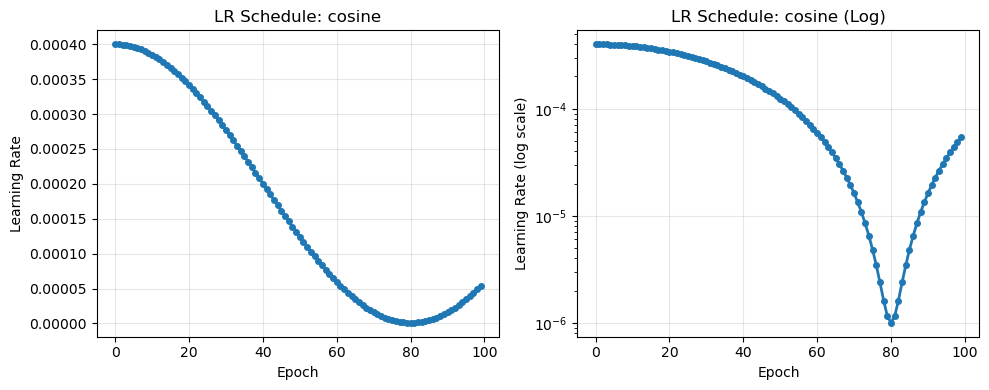

📈 LR Schedule Preview:
   Epoch  1: 4.00e-04
   Epoch  2: 4.00e-04
   Epoch  3: 3.99e-04
   Epoch  4: 3.99e-04
   Epoch  5: 3.98e-04
   Epoch  6: 3.96e-04
   Epoch  7: 3.94e-04
   Epoch  8: 3.93e-04
   Epoch  9: 3.90e-04
   Epoch 10: 3.88e-04
   ...     : ...
   Epoch 100: 5.40e-05


In [14]:
# Learning Rate Scheduler 설정
def create_lr_scheduler(optimizer, config):
    """Configuration에 따라 적절한 LR scheduler를 생성합니다."""
    
    if config.lr_scheduler is None:
        print("🚫 Learning rate scheduler: None (constant LR)")
        return None
    
    elif config.lr_scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config.cosine_T_max,
            eta_min=config.cosine_eta_min
        )
        print(f"📊 Learning rate scheduler: CosineAnnealingLR")
        print(f"   T_max: {config.cosine_T_max}, eta_min: {config.cosine_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'cosine_warm_restarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config.wr_T_0,
            T_mult=config.wr_T_mult,
            eta_min=config.wr_eta_min
        )
        print(f"🔄 Learning rate scheduler: CosineAnnealingWarmRestarts")
        print(f"   T_0: {config.wr_T_0}, T_mult: {config.wr_T_mult}, eta_min: {config.wr_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',  # validation loss를 minimize
            factor=config.rop_factor,
            patience=config.rop_patience,
            min_lr=config.rop_min_lr,
        )
        print(f"📉 Learning rate scheduler: ReduceLROnPlateau")
        print(f"   factor: {config.rop_factor}, patience: {config.rop_patience}, min_lr: {config.rop_min_lr}")
        return scheduler
    
    else:
        print(f"❌ Unknown scheduler: {config.lr_scheduler}, using None")
        return None

# Scheduler 생성
lr_scheduler = create_lr_scheduler(optimizer, scfg)

print(f"\n🎯 Current configuration:")
print(f"   Initial LR: {scfg.lr}")
print(f"   Scheduler: {scfg.lr_scheduler}")
print(f"   Epochs: {scfg.epochs}")

# 스케줄러별 LR 변화 시뮬레이션 (시각화용)
def simulate_lr_schedule(config, num_epochs=20):
    """LR 스케줄 변화를 시뮬레이션합니다."""
    import copy
    
    # 임시 optimizer 생성
    temp_param = torch.nn.Parameter(torch.randn(1))
    temp_opt = torch.optim.AdamW([temp_param], lr=config.lr)
    temp_scheduler = create_lr_scheduler(temp_opt, config)
    
    lrs = []
    val_losses = [1.0, 0.9, 0.85, 0.8, 0.85, 0.82, 0.81, 0.80, 0.82, 0.79,
                  0.78, 0.77, 0.78, 0.76, 0.75, 0.76, 0.74, 0.73, 0.74, 0.72]  # 가상의 validation loss
    
    for epoch in range(num_epochs):
        lrs.append(temp_opt.param_groups[0]['lr'])
        
        if temp_scheduler is not None:
            if config.lr_scheduler == 'reduce_on_plateau':
                # ReduceLROnPlateau의 경우 validation loss 필요
                val_loss = val_losses[epoch] if epoch < len(val_losses) else val_losses[-1]
                temp_scheduler.step(val_loss)
            else:
                # 다른 스케줄러는 epoch만 필요
                temp_scheduler.step()
    
    return lrs

# LR 스케줄 시각화
if scfg.lr_scheduler is not None:
    lrs = simulate_lr_schedule(scfg, scfg.epochs)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(lrs, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'LR Schedule: {scfg.lr_scheduler}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(lrs, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate (log scale)')
    plt.title(f'LR Schedule: {scfg.lr_scheduler} (Log)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 LR Schedule Preview:")
    for i, lr in enumerate(lrs[:10]):  # 처음 10 epoch만 표시
        print(f"   Epoch {i+1:2d}: {lr:.2e}")
    if len(lrs) > 10:
        print(f"   ...     : ...")
        print(f"   Epoch {len(lrs):2d}: {lrs[-1]:.2e}")
else:
    print("📊 No scheduler selected - constant learning rate will be used.")

# wandb set-up

In [15]:
# === Weights & Biases init ===
# scfg에 project/name/tags가 없더라도 안전하게 동작하도록 기본값 준비
wandb_init_kwargs = dict(
    project=getattr(scfg, "wandb_project", "airfrans-gnn"),
    name=getattr(scfg, "wandb_run_name", None),           # ex) f"exp_{time.time():.0f}"
    tags=getattr(scfg, "wandb_tags", None),               # ex) ["physics", "navier-stokes"]
    mode=getattr(scfg, "wandb_mode", "online"),           # "online"|"offline"|"disabled"
    settings=wandb.Settings(start_method="thread"),
    config={
        # 기본 하이퍼 파라미터를 config로 기록
        "epochs": getattr(scfg, "epochs", None),
        "batch_size": getattr(scfg, "batch_size", None),
        "lr": getattr(scfg, "lr", None),
        "optimizer": getattr(scfg, "optimizer", "adam"),
        "scheduler": getattr(scfg, "scheduler", None),
        "amp": getattr(scfg, "amp", False),
        # physics loss 주요 값
        "cont_w0": getattr(loss_fn, "cont_w0", None),
        "cont_w_target": getattr(loss_fn, "cont_w_target", None),
        "mom_w0": getattr(loss_fn, "mom_w0", None),
        "mom_w_target": getattr(loss_fn, "mom_w_target", None),
        "ramp_steps": getattr(loss_fn, "curr_steps", None),
        "ramp_start_step": getattr(loss_fn, "ramp_start_step", 0),
    }
)
wandb_run = wandb.init(**wandb_init_kwargs)

# Make wandb log per-epoch only: swallow per-step logs (commit=False)
try:
    _wandb_orig_log = wandb.log
    def _log_epoch_only(data=None, step=None, commit=None, *args, **kwargs):
        # Preserve default behavior: commit defaults to True when not provided
        if commit is None:
            commit = True
        # Ignore any step-level logs that explicitly use commit=False
        if commit is False:
            return
        return _wandb_orig_log(data, step=step, commit=commit, *args, **kwargs)
    wandb.log = _log_epoch_only
except Exception:
    pass

# Disable gradient/parameter histogram logging (step-based)
try:
    # Previously: wandb.watch(model, log="gradients", log_freq=100)
    # Avoid step-wise logging entirely
    pass  # skip watch
except Exception:
    pass


wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: Currently logged in as: jyk-snuai (jyk-snuai-seoul-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 10. Execute training loop

In [16]:
# Enhanced Training Loop with Optimized W&B Artifact Management
def train_with_scheduler(model, optim, scheduler, train_loader, val_loader, 
                        scfg, device, scaler=None, physics_loss_fn=None):
    scaler = GradScaler(enabled=(scfg.amp and torch.cuda.is_available()))
    global_step = 0
    best_val = float('inf')
    
    # Artifact 관리 설정
    USE_WANDB_ARTIFACTS = getattr(scfg, "use_wandb_artifacts", False)  # 기본값 False
    ARTIFACT_SAVE_BEST_ONLY = getattr(scfg, "artifact_save_best_only", True)  # best만 저장
    ARTIFACT_SAVE_INTERVAL = getattr(scfg, "artifact_save_interval", 20)  # 20 epochs마다
    
    EPOCHS = getattr(scfg, "epochs", 50)
    ckpt_dir = getattr(scfg, "ckpt_dir", "checkpoints")
    ckpt_interval = max(1, getattr(scfg, "ckpt_interval", 5))
    
    # Artifact 히스토리 추적
    artifact_history = {
        'best_uploaded': False,
        'last_periodic_epoch': -1,
        'total_artifacts': 0
    }

    for epoch in range(EPOCHS):
        train_total, train_logs, global_step = train_epoch(
            train_loader, model, optim, device, scaler,
            desc=f"train[{epoch}]", loss_fn=physics_loss_fn,
            global_step_start=global_step,
            scheduler=scheduler,
            scheduler_step_mode=("step" if getattr(scfg, "scheduler_step_per_batch", False) else "epoch"),
            log_every_n_steps=getattr(scfg, "log_every_n_steps", 25)
        )

        val_total, val_logs = run_epoch(val_loader, model, device, loss_fn=physics_loss_fn)

        # === wandb epoch-level logging (항상 수행) ===
        log_epoch = {
            "epoch": epoch,
            "train/total_epoch": train_logs['total_loss'],
            "train/mse_epoch": train_logs['mse_loss'],
            "train/continuity_epoch": train_logs.get('continuity_loss', float('nan')),
            "train/momentum_epoch": train_logs.get('momentum_loss', float('nan')),
            "train/bc_epoch": train_logs.get('bc_loss', float('nan')),
            "val/total_epoch": val_logs['total_loss'],
            "val/mse_epoch": val_logs['mse_loss'],
            "val/continuity_epoch": val_logs.get('continuity_loss', float('nan')),
            "val/momentum_epoch": val_logs.get('momentum_loss', float('nan')),
            "val/bc_epoch": val_logs.get('bc_loss', float('nan')),
        }
        if 'cont_weight_used' in train_logs: 
            log_epoch["weight/cont_used_epoch"] = train_logs['cont_weight_used']
        if 'mom_weight_used' in train_logs: 
            log_epoch["weight/mom_used_epoch"] = train_logs['mom_weight_used']
        lr_now = get_lr(optim)
        if lr_now is not None:
            log_epoch["lr_epoch"] = lr_now
        wandb.log(log_epoch, step=global_step, commit=True)

        # === Learning Rate Scheduler Step ===
        if scheduler is not None and not getattr(scfg, "scheduler_step_per_batch", False):
            from torch.optim.lr_scheduler import ReduceLROnPlateau
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_total)
            else:
                scheduler.step()

        # === Checkpoint 저장 (로컬 파일시스템) ===
        os.makedirs(ckpt_dir, exist_ok=True)
        
        # Best model 저장
        is_best = val_total < best_val
        if is_best:
            best_val = val_total
            best_path = os.path.join(ckpt_dir, "best.pt")
            torch.save({
                "model": model.state_dict(),
                "optimizer": optim.state_dict(),
                "scheduler": (scheduler.state_dict() if scheduler is not None else None),
                "scaler": (scaler.state_dict() if scaler is not None else None),
                "epoch": epoch,
                "global_step": global_step,
                "best_val": best_val,
                "train_logs": train_logs,
                "val_logs": val_logs
            }, best_path)
            
            # W&B Artifact 업로드 (조건부)
            if USE_WANDB_ARTIFACTS:
                try:
                    # 이전 best artifact가 있으면 삭제 (선택적)
                    if artifact_history['best_uploaded']:
                        # W&B는 자동으로 버전 관리하므로 별도 삭제 불필요
                        pass
                    
                    # 새로운 best artifact 업로드
                    art = wandb.Artifact(
                        name=f"model-best",  # 고정된 이름 사용
                        type="model",
                        description=f"Best model at epoch {epoch} with val_loss={val_total:.4f}",
                        metadata={
                            "epoch": epoch,
                            "val_loss": val_total,
                            "train_loss": train_total,
                            "best_val": best_val
                        }
                    )
                    art.add_file(best_path)
                    wandb.run.log_artifact(art)
                    artifact_history['best_uploaded'] = True
                    artifact_history['total_artifacts'] += 1
                    print(f"  📤 W&B Artifact uploaded: best model (epoch {epoch})")
                except Exception as e:
                    print(f"  ⚠️ Failed to upload W&B artifact: {e}")

        # Periodic checkpoint 저장
        if (epoch + 1) % ckpt_interval == 0:
            ep_path = os.path.join(ckpt_dir, f"epoch_{epoch+1}.pt")
            torch.save({
                "model": model.state_dict(),
                "optimizer": optim.state_dict(),
                "scheduler": (scheduler.state_dict() if scheduler is not None else None),
                "scaler": (scaler.state_dict() if scaler is not None else None),
                "epoch": epoch,
                "global_step": global_step,
                "best_val": best_val
            }, ep_path)
            
            # Periodic artifact 업로드 (매우 제한적으로)
            if USE_WANDB_ARTIFACTS and not ARTIFACT_SAVE_BEST_ONLY:
                if (epoch + 1) % ARTIFACT_SAVE_INTERVAL == 0:
                    try:
                        art = wandb.Artifact(
                            name=f"model-checkpoint",
                            type="model",
                            description=f"Checkpoint at epoch {epoch+1}",
                            metadata={
                                "epoch": epoch + 1,
                                "val_loss": val_total,
                                "train_loss": train_total
                            }
                        )
                        art.add_file(ep_path)
                        wandb.run.log_artifact(art, aliases=[f"epoch-{epoch+1}"])
                        artifact_history['last_periodic_epoch'] = epoch + 1
                        artifact_history['total_artifacts'] += 1
                        print(f"  📤 W&B Artifact uploaded: checkpoint (epoch {epoch+1})")
                    except Exception as e:
                        print(f"  ⚠️ Failed to upload periodic artifact: {e}")

        # Print epoch summary
        print(f"Epoch {epoch:3d} | Train: total={train_total:.4f} mse={train_logs['mse_loss']:.4f} "
              f"cont={train_logs.get('continuity_loss', 0):.2e} mom={train_logs.get('momentum_loss', 0):.2e} "
              f"bc={train_logs.get('bc_loss', 0):.2e} | "
              f"Val: total={val_total:.4f} bc={val_logs.get('bc_loss', 0):.2e}"
              f" {'[BEST]' if is_best else ''}")

    # === Training 완료 후 최종 artifact ===
    if USE_WANDB_ARTIFACTS:
        # 최종 모델 저장
        final_path = os.path.join(ckpt_dir, "final.pt")
        torch.save({
            "model": model.state_dict(),
            "optimizer": optim.state_dict(),
            "scheduler": (scheduler.state_dict() if scheduler is not None else None),
            "scaler": (scaler.state_dict() if scaler is not None else None),
            "epoch": EPOCHS - 1,
            "global_step": global_step,
            "best_val": best_val
        }, final_path)
        
        try:
            art = wandb.Artifact(
                name=f"model-final",
                type="model",
                description=f"Final model after {EPOCHS} epochs",
                metadata={
                    "total_epochs": EPOCHS,
                    "best_val": best_val,
                    "total_artifacts": artifact_history['total_artifacts']
                }
            )
            art.add_file(final_path)
            art.add_file(os.path.join(ckpt_dir, "best.pt"), name="best.pt")  # best도 포함
            wandb.run.log_artifact(art, aliases=["latest", "final"])
            print(f"\n📤 Final W&B Artifact uploaded with {artifact_history['total_artifacts']+1} total artifacts")
        except Exception as e:
            print(f"⚠️ Failed to upload final artifact: {e}")

    # 종료
    wandb.finish()
    
    return {
        'lr_history': [],
        'train_total_loss': [],
        'train_continuity_loss': [],
        'train_bc_loss': [],
        'val_total_loss': [],
        'val_continuity_loss': [],
        'val_bc_loss': [],
        'artifacts_uploaded': artifact_history['total_artifacts']
    }

# 훈련 실행 함수 (Physics Loss 지원)
def run_training_experiment(config_updates=None, physics_config_updates=None):
    """
    설정을 업데이트하고 physics loss와 함께 훈련을 실행합니다.
    
    Args:
        config_updates: 모델 설정 변경 딕셔너리 (예: {'lr_scheduler': 'cosine'})
        physics_config_updates: Physics loss 설정 변경 딕셔너리
    """
    
    # 설정 업데이트
    if config_updates:
        for key, value in config_updates.items():
            setattr(scfg, key, value)
        print(f"🔧 Model configuration updated: {config_updates}")
    


    # 새로운 optimizer와 scheduler 생성
    optimizer = torch.optim.AdamW(model.parameters(), 
                                 lr=scfg.lr, 
                                 weight_decay=scfg.weight_decay, 
                                 betas=scfg.betas, 
                                 eps=scfg.eps)
    
    scheduler = create_lr_scheduler(optimizer, scfg)
    
    # GradScaler for AMP
    scaler = torch.cuda.amp.GradScaler() if scfg.amp and torch.cuda.is_available() else None
    
    # 훈련 실행
    history = train_with_scheduler(
        model, optimizer, scheduler, train_loader, val_loader, 
        scfg, device, scaler, physics_loss_fn=loss_fn
    )
    
    return history


# 스케줄러 및 Physics Loss 테스트
print(f"Current scheduler: {scfg.lr_scheduler}")

if lr_scheduler is None:
    print("⚠️  No scheduler active - training with constant LR")
else:
    print(f"✅ Scheduler ready: {type(lr_scheduler).__name__}")

print(f"\n🧪 Running test training with physics loss...")

# 짧은 훈련으로 테스트 (physics loss 포함)
test_history = run_training_experiment()

print(f"\n📊 Test Results with Physics Loss:")
if test_history['lr_history']:
    print(f"   LR progression: {' -> '.join([f'{lr:.2e}' for lr in test_history['lr_history']])}")
    print(f"   Train losses (total): {' -> '.join([f'{loss:.4f}' for loss in test_history['train_total_loss']])}")
    print(f"   Train losses (continuity): {' -> '.join([f'{loss:.2e}' for loss in test_history['train_continuity_loss']])}")
    print(f"   Val losses (total): {' -> '.join([f'{loss:.4f}' for loss in test_history['val_total_loss']])}")
    print(f"   Val losses (continuity): {' -> '.join([f'{loss:.2e}' for loss in test_history['val_continuity_loss']])}")
else:
    print("   Training was interrupted before any results could be recorded.")


Current scheduler: cosine
✅ Scheduler ready: CosineAnnealingLR

🧪 Running test training with physics loss...
📊 Learning rate scheduler: CosineAnnealingLR
   T_max: 80, eta_min: 1e-06


C:\Users\Kim\AppData\Local\Temp\ipykernel_25724\2305599595.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(scfg.amp and torch.cuda.is_available()))


train[0]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Kim\AppData\Local\Temp\ipykernel_25724\3869139614.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with (autocast(enabled=(scfg.amp and torch.cuda.is_available()))


Epoch   0 | Train: total=69.2664 mse=1.1278 cont=4.54e-04 mom=1.36e+03 bc=4.60e-02 | Val: total=0.8045 bc=1.05e-02 [BEST]


train[1]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1 | Train: total=2.2368 mse=1.0058 cont=1.69e-04 mom=2.46e+01 bc=2.87e-02 | Val: total=0.6817 bc=1.23e-02 [BEST]


train[2]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   2 | Train: total=1.4394 mse=1.0053 cont=1.90e-04 mom=8.68e+00 bc=1.37e-02 | Val: total=0.6573 bc=1.07e-02 [BEST]


train[3]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   3 | Train: total=1.2233 mse=1.0063 cont=2.35e-04 mom=4.34e+00 bc=5.00e-02 | Val: total=0.6509 bc=1.14e-02 [BEST]


train[4]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   4 | Train: total=1.0976 mse=1.0061 cont=2.20e-04 mom=1.83e+00 bc=4.37e-02 | Val: total=0.6476 bc=1.12e-02 [BEST]


train[5]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   5 | Train: total=1.0458 mse=1.0047 cont=1.51e-04 mom=8.22e-01 bc=1.10e-02 | Val: total=0.6442 bc=1.02e-02 [BEST]


train[6]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   6 | Train: total=1.0401 mse=1.0040 cont=1.86e-04 mom=7.19e-01 bc=2.73e-02 | Val: total=0.6432 bc=1.01e-02 [BEST]


train[7]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   7 | Train: total=1.0342 mse=1.0030 cont=1.24e-04 mom=6.23e-01 bc=1.05e-02 | Val: total=0.6423 bc=9.89e-03 [BEST]


train[8]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   8 | Train: total=1.0376 mse=1.0026 cont=1.83e-04 mom=6.97e-01 bc=2.68e-02 | Val: total=0.6416 bc=9.78e-03 [BEST]


train[9]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch   9 | Train: total=1.0300 mse=1.0020 cont=1.43e-04 mom=5.59e-01 bc=1.09e-02 | Val: total=0.6424 bc=1.00e-02 


train[10]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  10 | Train: total=1.0331 mse=1.0015 cont=1.85e-04 mom=6.26e-01 bc=3.64e-02 | Val: total=0.6414 bc=9.89e-03 [BEST]


train[11]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  11 | Train: total=1.0218 mse=1.0016 cont=1.06e-04 mom=4.02e-01 bc=9.93e-03 | Val: total=0.6403 bc=9.79e-03 [BEST]


train[12]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  12 | Train: total=1.0236 mse=1.0013 cont=9.50e-05 mom=4.44e-01 bc=9.86e-03 | Val: total=0.6414 bc=9.72e-03 


train[13]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  13 | Train: total=1.0215 mse=1.0006 cont=1.38e-04 mom=4.15e-01 bc=1.42e-02 | Val: total=0.6404 bc=9.70e-03 


train[14]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  14 | Train: total=1.0173 mse=1.0008 cont=9.28e-05 mom=3.30e-01 bc=9.91e-03 | Val: total=0.6390 bc=9.68e-03 [BEST]


train[15]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  15 | Train: total=1.0160 mse=1.0009 cont=7.53e-05 mom=3.00e-01 bc=9.84e-03 | Val: total=0.6387 bc=9.65e-03 [BEST]


train[16]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  16 | Train: total=1.0139 mse=1.0009 cont=6.48e-05 mom=2.58e-01 bc=9.78e-03 | Val: total=0.6397 bc=9.67e-03 


train[17]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  17 | Train: total=1.0151 mse=1.0009 cont=1.15e-04 mom=2.81e-01 bc=1.45e-02 | Val: total=0.6387 bc=9.71e-03 


train[18]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  18 | Train: total=1.0117 mse=1.0011 cont=8.19e-05 mom=2.10e-01 bc=9.90e-03 | Val: total=0.6394 bc=9.70e-03 


train[19]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  19 | Train: total=1.0126 mse=1.0006 cont=1.03e-04 mom=2.37e-01 bc=1.12e-02 | Val: total=0.6378 bc=9.64e-03 [BEST]


train[20]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  20 | Train: total=1.0083 mse=1.0005 cont=8.56e-05 mom=1.54e-01 bc=1.16e-02 | Val: total=0.6382 bc=9.67e-03 


train[21]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  21 | Train: total=1.0085 mse=1.0006 cont=9.43e-05 mom=1.56e-01 bc=1.11e-02 | Val: total=0.6381 bc=9.65e-03 


train[22]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  22 | Train: total=1.0064 mse=1.0007 cont=9.08e-05 mom=1.12e-01 bc=1.10e-02 | Val: total=0.6375 bc=9.63e-03 [BEST]


train[23]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  23 | Train: total=1.0051 mse=1.0006 cont=8.61e-05 mom=8.79e-02 bc=1.01e-02 | Val: total=0.6382 bc=9.65e-03 


train[24]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  24 | Train: total=1.0059 mse=1.0006 cont=9.61e-05 mom=1.01e-01 bc=1.08e-02 | Val: total=0.6380 bc=9.64e-03 


train[25]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  25 | Train: total=1.0050 mse=1.0006 cont=8.46e-05 mom=8.43e-02 bc=1.06e-02 | Val: total=0.6381 bc=9.64e-03 


train[26]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  26 | Train: total=1.0040 mse=1.0007 cont=6.42e-05 mom=6.33e-02 bc=9.75e-03 | Val: total=0.6378 bc=9.64e-03 


train[27]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  27 | Train: total=1.0035 mse=1.0005 cont=5.37e-05 mom=5.60e-02 bc=9.72e-03 | Val: total=0.6374 bc=9.65e-03 [BEST]


train[28]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  28 | Train: total=1.0025 mse=1.0009 cont=4.28e-05 mom=2.94e-02 bc=9.69e-03 | Val: total=0.6377 bc=9.67e-03 


train[29]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  29 | Train: total=1.0024 mse=1.0006 cont=7.43e-05 mom=3.32e-02 bc=1.07e-02 | Val: total=0.6375 bc=9.66e-03 


train[30]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  30 | Train: total=1.0016 mse=1.0002 cont=7.57e-05 mom=2.40e-02 bc=1.06e-02 | Val: total=0.6371 bc=9.65e-03 [BEST]


train[31]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  31 | Train: total=1.0019 mse=1.0007 cont=6.86e-05 mom=1.90e-02 bc=1.04e-02 | Val: total=0.6368 bc=9.65e-03 [BEST]


train[32]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  32 | Train: total=1.0013 mse=1.0004 cont=3.76e-05 mom=1.32e-02 bc=9.68e-03 | Val: total=0.6367 bc=9.65e-03 [BEST]


train[33]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  33 | Train: total=1.0012 mse=1.0000 cont=6.69e-05 mom=1.82e-02 bc=9.96e-03 | Val: total=0.6365 bc=9.65e-03 [BEST]


train[34]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  34 | Train: total=1.0014 mse=1.0004 cont=3.46e-05 mom=1.38e-02 bc=9.71e-03 | Val: total=0.6363 bc=9.66e-03 [BEST]


train[35]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  35 | Train: total=1.0016 mse=1.0006 cont=4.58e-05 mom=1.38e-02 bc=9.97e-03 | Val: total=0.6362 bc=9.67e-03 [BEST]


train[36]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  36 | Train: total=1.0014 mse=1.0006 cont=4.26e-05 mom=1.16e-02 bc=9.87e-03 | Val: total=0.6360 bc=9.67e-03 [BEST]


train[37]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  37 | Train: total=1.0009 mse=1.0000 cont=4.58e-05 mom=1.33e-02 bc=9.99e-03 | Val: total=0.6358 bc=9.67e-03 [BEST]


train[38]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  38 | Train: total=1.0011 mse=1.0002 cont=4.28e-05 mom=1.13e-02 bc=9.90e-03 | Val: total=0.6357 bc=9.68e-03 [BEST]


train[39]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  39 | Train: total=1.0015 mse=1.0007 cont=2.82e-05 mom=9.87e-03 bc=9.72e-03 | Val: total=0.6357 bc=9.69e-03 [BEST]


train[40]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  40 | Train: total=1.0010 mse=1.0002 cont=3.95e-05 mom=9.41e-03 bc=9.86e-03 | Val: total=0.6356 bc=9.69e-03 [BEST]


train[41]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  41 | Train: total=1.0009 mse=1.0001 cont=2.31e-05 mom=8.65e-03 bc=9.72e-03 | Val: total=0.6354 bc=9.69e-03 [BEST]


train[42]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  42 | Train: total=1.0011 mse=1.0004 cont=2.32e-05 mom=7.87e-03 bc=9.73e-03 | Val: total=0.6354 bc=9.70e-03 [BEST]


train[43]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  43 | Train: total=1.0009 mse=1.0002 cont=2.09e-05 mom=6.22e-03 bc=9.73e-03 | Val: total=0.6353 bc=9.70e-03 [BEST]


train[44]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  44 | Train: total=2.0558 mse=1.0024 cont=2.19e-05 mom=1.78e+01 bc=9.90e-03 | Val: total=0.6352 bc=9.71e-03 [BEST]


train[45]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  45 | Train: total=1.0005 mse=0.9999 cont=1.68e-05 mom=5.87e-03 bc=9.74e-03 | Val: total=0.6350 bc=9.72e-03 [BEST]


train[46]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  46 | Train: total=1.0496 mse=1.0007 cont=1.48e-05 mom=8.10e-01 bc=9.78e-03 | Val: total=0.6350 bc=9.73e-03 


train[47]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  47 | Train: total=1.1940 mse=1.0007 cont=2.64e-05 mom=3.16e+00 bc=1.00e-02 | Val: total=0.6349 bc=9.74e-03 [BEST]


train[48]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  48 | Train: total=1.0005 mse=1.0000 cont=1.55e-05 mom=4.20e-03 bc=9.76e-03 | Val: total=0.6348 bc=9.73e-03 [BEST]


train[49]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  49 | Train: total=1.0010 mse=1.0004 cont=2.18e-05 mom=4.35e-03 bc=9.90e-03 | Val: total=0.6347 bc=9.74e-03 [BEST]


train[50]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  50 | Train: total=1.0009 mse=1.0003 cont=2.02e-05 mom=5.29e-03 bc=9.82e-03 | Val: total=0.6347 bc=9.74e-03 [BEST]


train[51]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  51 | Train: total=1.0010 mse=1.0004 cont=1.03e-05 mom=4.07e-03 bc=9.76e-03 | Val: total=0.6346 bc=9.75e-03 [BEST]


train[52]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  52 | Train: total=1.0007 mse=0.9998 cont=1.20e-05 mom=8.36e-03 bc=9.77e-03 | Val: total=0.6344 bc=9.75e-03 [BEST]


train[53]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  53 | Train: total=1.0008 mse=0.9998 cont=1.05e-05 mom=9.24e-03 bc=9.77e-03 | Val: total=0.6342 bc=9.75e-03 [BEST]


train[54]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  54 | Train: total=1.0005 mse=0.9999 cont=1.06e-05 mom=4.58e-03 bc=9.79e-03 | Val: total=0.6342 bc=9.76e-03 [BEST]


train[55]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  55 | Train: total=1.0005 mse=0.9996 cont=8.84e-06 mom=9.76e-03 bc=9.79e-03 | Val: total=0.6339 bc=9.77e-03 [BEST]


train[56]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  56 | Train: total=0.9997 mse=0.9990 cont=1.52e-05 mom=6.17e-03 bc=1.03e-02 | Val: total=0.6337 bc=9.78e-03 [BEST]


train[57]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  57 | Train: total=1.0011 mse=1.0001 cont=6.21e-06 mom=1.03e-02 bc=9.81e-03 | Val: total=0.6334 bc=9.79e-03 [BEST]


train[58]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  58 | Train: total=1.0006 mse=0.9994 cont=1.27e-05 mom=1.24e-02 bc=1.11e-02 | Val: total=0.6332 bc=9.80e-03 [BEST]


train[59]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  59 | Train: total=1.0583 mse=0.9985 cont=7.06e-06 mom=8.66e-01 bc=9.90e-03 | Val: total=0.6330 bc=9.82e-03 [BEST]


train[60]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  60 | Train: total=1.0094 mse=0.9970 cont=1.47e-05 mom=1.72e-01 bc=1.37e-02 | Val: total=0.6395 bc=9.87e-03 


train[61]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  61 | Train: total=1.4217 mse=1.0041 cont=8.45e-06 mom=5.98e+00 bc=1.68e-02 | Val: total=0.6418 bc=1.13e-02 


train[62]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  62 | Train: total=1.1056 mse=1.0094 cont=8.82e-06 mom=1.36e+00 bc=1.14e-02 | Val: total=0.6390 bc=1.20e-02 


train[63]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  63 | Train: total=1.2422 mse=1.0064 cont=2.04e-05 mom=3.24e+00 bc=1.62e-01 | Val: total=0.6361 bc=1.04e-02 


train[64]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  64 | Train: total=1.3134 mse=1.0034 cont=2.44e-05 mom=4.28e+00 bc=7.25e-02 | Val: total=0.6345 bc=9.96e-03 


train[65]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  65 | Train: total=1.0893 mse=1.0019 cont=1.47e-05 mom=1.20e+00 bc=1.10e-02 | Val: total=0.6362 bc=9.94e-03 


train[66]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  66 | Train: total=1.1025 mse=1.0006 cont=3.26e-05 mom=1.37e+00 bc=4.95e-02 | Val: total=0.6336 bc=9.99e-03 


train[67]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  67 | Train: total=1.0347 mse=1.0006 cont=1.74e-05 mom=4.59e-01 bc=1.08e-02 | Val: total=0.6329 bc=1.00e-02 [BEST]


train[68]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  68 | Train: total=1.0433 mse=0.9997 cont=2.17e-05 mom=5.82e-01 bc=1.13e-02 | Val: total=0.6332 bc=1.00e-02 


train[69]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  69 | Train: total=1.0826 mse=0.9999 cont=3.74e-05 mom=1.09e+00 bc=4.14e-02 | Val: total=0.6330 bc=1.01e-02 


train[70]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  70 | Train: total=1.0482 mse=0.9991 cont=3.95e-05 mom=6.27e-01 bc=3.96e-02 | Val: total=0.6328 bc=1.01e-02 [BEST]


train[71]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  71 | Train: total=1.0239 mse=0.9993 cont=2.40e-05 mom=3.18e-01 bc=1.13e-02 | Val: total=0.6325 bc=1.01e-02 [BEST]


train[72]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  72 | Train: total=1.0312 mse=0.9989 cont=3.79e-05 mom=3.98e-01 bc=3.98e-02 | Val: total=0.6327 bc=1.01e-02 


train[73]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  73 | Train: total=1.0142 mse=0.9989 cont=2.42e-05 mom=1.91e-01 bc=1.09e-02 | Val: total=0.6324 bc=1.01e-02 [BEST]


train[74]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  74 | Train: total=1.0404 mse=0.9986 cont=4.41e-05 mom=5.16e-01 bc=3.65e-02 | Val: total=0.6325 bc=1.01e-02 


train[75]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  75 | Train: total=1.0127 mse=0.9985 cont=2.71e-05 mom=1.75e-01 bc=1.10e-02 | Val: total=0.6324 bc=1.01e-02 [BEST]


train[76]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  76 | Train: total=1.0095 mse=0.9984 cont=2.40e-05 mom=1.34e-01 bc=1.08e-02 | Val: total=0.6324 bc=1.01e-02 [BEST]


train[77]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  77 | Train: total=1.0088 mse=0.9985 cont=2.14e-05 mom=1.22e-01 bc=1.03e-02 | Val: total=0.6324 bc=1.02e-02 [BEST]


train[78]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  78 | Train: total=1.0071 mse=0.9989 cont=2.16e-05 mom=9.46e-02 bc=1.07e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[79]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  79 | Train: total=1.0069 mse=0.9986 cont=2.44e-05 mom=9.59e-02 bc=1.09e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[80]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  80 | Train: total=1.0078 mse=0.9989 cont=2.87e-05 mom=1.02e-01 bc=1.11e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[81]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  81 | Train: total=1.0092 mse=0.9985 cont=2.70e-05 mom=1.23e-01 bc=1.10e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[82]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  82 | Train: total=1.0104 mse=0.9984 cont=2.72e-05 mom=1.38e-01 bc=1.12e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[83]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  83 | Train: total=1.0091 mse=0.9985 cont=2.02e-05 mom=1.22e-01 bc=1.02e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[84]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  84 | Train: total=1.0119 mse=0.9988 cont=2.70e-05 mom=1.48e-01 bc=1.10e-02 | Val: total=0.6323 bc=1.02e-02 


train[85]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  85 | Train: total=1.0112 mse=0.9988 cont=2.88e-05 mom=1.41e-01 bc=1.12e-02 | Val: total=0.6323 bc=1.02e-02 


train[86]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  86 | Train: total=1.0138 mse=0.9984 cont=2.52e-05 mom=1.75e-01 bc=1.09e-02 | Val: total=0.6323 bc=1.02e-02 [BEST]


train[87]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  87 | Train: total=1.0261 mse=0.9987 cont=4.90e-05 mom=2.99e-01 bc=3.52e-02 | Val: total=0.6327 bc=1.02e-02 


train[88]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  88 | Train: total=1.0098 mse=0.9987 cont=2.94e-05 mom=1.22e-01 bc=1.12e-02 | Val: total=0.6325 bc=1.02e-02 


train[89]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  89 | Train: total=1.0162 mse=0.9994 cont=2.81e-05 mom=1.87e-01 bc=1.11e-02 | Val: total=0.6326 bc=1.02e-02 


train[90]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  90 | Train: total=1.0367 mse=0.9993 cont=4.96e-05 mom=4.05e-01 bc=3.58e-02 | Val: total=0.6325 bc=1.02e-02 


train[91]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  91 | Train: total=1.0246 mse=0.9995 cont=3.17e-05 mom=2.77e-01 bc=1.12e-02 | Val: total=0.6321 bc=1.02e-02 [BEST]


train[92]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  92 | Train: total=1.0444 mse=0.9994 cont=4.43e-05 mom=4.87e-01 bc=3.27e-02 | Val: total=0.6322 bc=1.02e-02 


train[93]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  93 | Train: total=1.0309 mse=0.9992 cont=3.42e-05 mom=3.47e-01 bc=1.10e-02 | Val: total=0.6326 bc=1.01e-02 


train[94]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  94 | Train: total=1.0402 mse=0.9992 cont=3.62e-05 mom=4.48e-01 bc=1.05e-02 | Val: total=0.6328 bc=1.01e-02 


train[95]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  95 | Train: total=1.0246 mse=0.9997 cont=3.21e-05 mom=2.69e-01 bc=1.03e-02 | Val: total=0.6324 bc=1.02e-02 


train[96]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  96 | Train: total=1.0491 mse=0.9990 cont=5.87e-05 mom=5.41e-01 bc=1.19e-02 | Val: total=0.6319 bc=1.02e-02 [BEST]


train[97]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  97 | Train: total=1.0376 mse=0.9988 cont=5.29e-05 mom=4.14e-01 bc=1.27e-02 | Val: total=0.6325 bc=1.03e-02 


train[98]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  98 | Train: total=1.0347 mse=0.9983 cont=5.03e-05 mom=3.85e-01 bc=1.20e-02 | Val: total=0.6333 bc=1.05e-02 


train[99]:   0%|          | 0/90 [00:00<?, ?it/s]

val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch  99 | Train: total=1.0461 mse=0.9977 cont=4.95e-05 mom=5.13e-01 bc=1.08e-02 | Val: total=0.6291 bc=1.07e-02 [BEST]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
lr_epoch,██████▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂
train/bc_epoch,▃▅▃▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▁▁▁▁▁▁▁▄▁▁
train/continuity_epoch,▇█▅▆▆▄▅▃▄▄▄▂▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▁▂▂▂▂▂▃
train/momentum_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mse_epoch,▆▆▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁█▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁
train/total_epoch,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/bc_epoch,█▅▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▃▂▂▂▂▂▂▂▂▂▂▃▂▃▃▄
val/continuity_epoch,█▇▇▅▅▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃
val/momentum_epoch,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val/mse_epoch,▇██▇▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁



📊 Test Results with Physics Loss:
   Training was interrupted before any results could be recorded.


In [17]:
from utils import get_surface_mask, ensure_edge_features

# 14b) MSE per target (all, surface, volume) — computed in NORMALIZED space
@torch.no_grad()
def _surface_volume_masks_from_orig(d: Data):
    # Surface: non-zero normal vectors; Volume: zero normal vectors (use original, unnormalized normals)
    x = d.x
    if x is not None and x.size(1) >= 5:
        nxy = x[:, 3:5]
        surf = (nxy.abs().sum(dim=1) > 0)
    else:
        # Fallback to earlier heuristic
        surf = get_surface_mask(d)
    vol = ~surf
    return surf, vol

@torch.no_grad()
def _predict_one_local(d: Data):
    # Ensure pos3 and edges; normalize x; predict; keep EVERYTHING in normalized space for eval
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    # edges must already exist; do not build inline
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)

    # Build a CPU copy with normalized x/y for evaluation and metrics
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_norm.x_norm_params = {'mean': x_scaler.mean.clone(), 'scale': x_scaler.std.clone()}
    dm_norm.y_norm_params = {'mean': y_scaler.mean.clone(), 'scale': y_scaler.std.clone()}

    # Forward on device, return prediction in normalized space on CPU
    dm_run = dm_norm.to(device)
    with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
        y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def mse_per_channel(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor | None = None):
    # Ensure both tensors (and mask) are on the same device as y_pred
    dev = y_pred.device
    y_t = y_true.to(dev)
    if mask is not None:
        m = mask.to(dev)
        y_p = y_pred[m]
        y_t = y_t[m]
    else:
        y_p = y_pred
    err = (y_p - y_t) ** 2
    if err.numel() == 0:
        return [float('nan')] * y_true.size(1)
    return [float(err[:, i].mean().item()) for i in range(y_true.size(1))]

# Pick a sample (val if available else train) and report MSE splits (normalized space)
if isinstance(val_edges, list) and len(val_edges) > 0:
    d_eval = val_edges[0]
else:
    d_eval = train_edges[0] if len(train_edges) > 0 else None

if d_eval is not None:
    # Use original graph (unnormalized x) only for surface/volume masks
    d_orig = d_eval
    dm_eval_norm, y_pred_eval_norm = _predict_one_local(d_orig)
    surf_mask, vol_mask = _surface_volume_masks_from_orig(d_orig)

    names = ['u', 'v', 'p_over_rho', 'nu_t']
    mse_all = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, None)
    mse_surf = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, surf_mask)
    mse_vol  = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, vol_mask)

    print('[MSE | ALL   | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_all)})
    print('[MSE | SURF  | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_surf)})
    print('[MSE | VOLUME| normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_vol)})
else:
    print('No sample available for MSE computation')

[MSE | ALL   | normalized] {'u': '1.2338e+00', 'v': '4.1721e-01', 'p_over_rho': '6.2087e-02', 'nu_t': '1.5160e+00'}
[MSE | SURF  | normalized] {'u': '5.8950e+00', 'v': '3.1320e-01', 'p_over_rho': '5.4091e-01', 'nu_t': '1.2772e-03'}
[MSE | VOLUME| normalized] {'u': '9.1739e-01', 'v': '4.2427e-01', 'p_over_rho': '2.9582e-02', 'nu_t': '1.6189e+00'}


# Result Visualization

[Saved] figures\pred_vs_gt_channel2_20250920_223825.png


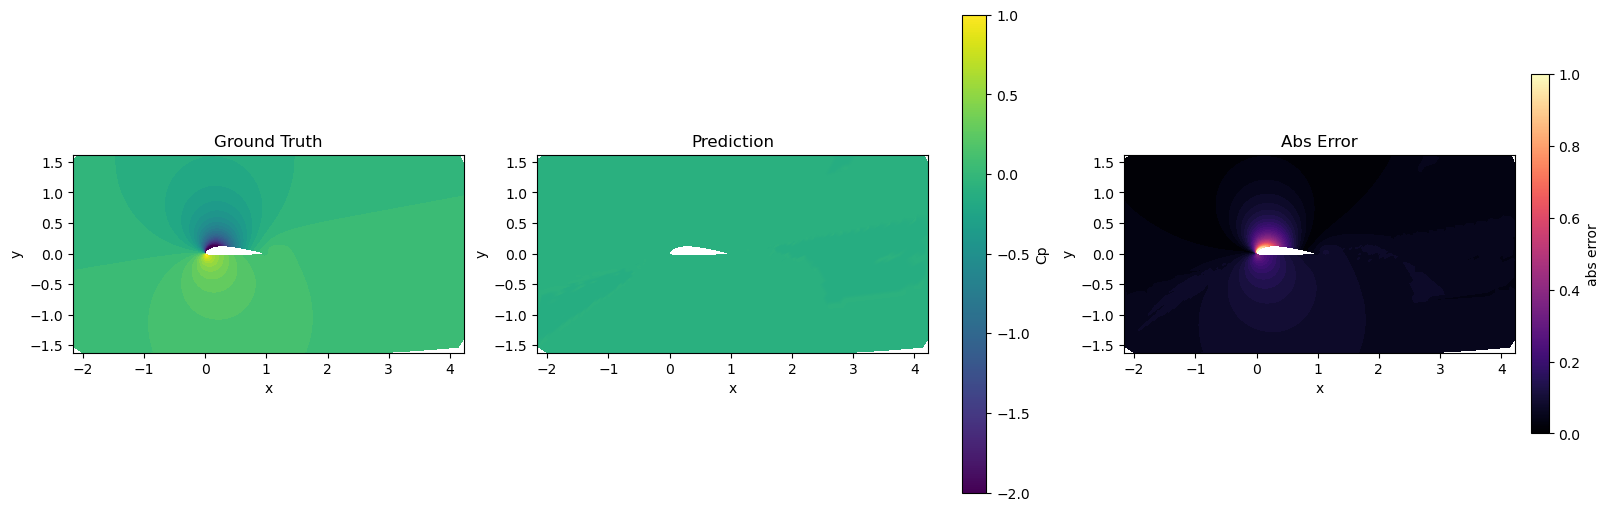

In [18]:
# 15) Visualization: GT vs Prediction (tricontour with optional mask)
from matplotlib.tri import Triangulation
from matplotlib.path import Path
from utils import _poly_from_surface
import os
from datetime import datetime

@torch.no_grad()
def _predict_one_for_viz(d: Data):
    # Ensure pos3 + edges, normalize x/y, forward, return normalized dm and y_pred_norm
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_run = dm_norm.to(device)
    
    # Temporarily disable AMP for visualization to avoid dtype issues
    model.eval()
    # Force float32 for visualization to avoid AMP dtype conflicts
    if hasattr(dm_run, 'x'):
        dm_run.x = dm_run.x.float()
    if hasattr(dm_run, 'edge_attr'):
        dm_run.edge_attr = dm_run.edge_attr.float()
        
    y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def plot_pred_vs_gt(dm: Data, y_pred: torch.Tensor, channel: int = 2, show_mesh: bool = True, mask_airfoil: bool = True,
                    titles: tuple[str,str,str] = ('Ground Truth','Prediction','Abs Error'), cmap: str = 'viridis',
                    denormalize: bool = True, save_dir: str = "figures", save: bool = True):
    # Optionally denormalize both GT and prediction for visualization
    if denormalize and hasattr(dm, 'y'):
        dm_y_cpu = dm.y.detach().cpu()
        y_pred_cpu = y_pred.detach().cpu()
        gt = y_scaler.inverse(dm_y_cpu)
        pr = y_scaler.inverse(y_pred_cpu)
    else:
        gt = dm.y.detach().cpu()
        pr = y_pred.detach().cpu()

    # Prepare coordinates and values
    xy = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().float().numpy()
    tri = Triangulation(xy[:,0], xy[:,1])

    # Denormalize x to physical for q and for robust airfoil polygon detection
    dm_x_cpu = dm.x.detach().cpu()
    x_phys = x_scaler.inverse(dm_x_cpu)  
    vx = float(x_phys[0, 0]); vy = float(x_phys[0, 1])
    v = math.sqrt(vx*vx + vy*vy)
    q = 0.5 * v * v

    gt_c = gt[:, channel].detach().cpu().float().numpy() / q
    pr_c = pr[:, channel].detach().cpu().float().numpy() / q
    err = np.abs(pr_c - gt_c)
    vmin = -2.0; vmax = 1.0

    # Optional mask of airfoil interior
    if mask_airfoil:
        try:
            x_np = x_phys.detach().cpu().numpy() if isinstance(x_phys, torch.Tensor) else np.asarray(x_phys)
            pos_np = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().numpy()
            surf_mask = None
            try:
                wall = x_np[:, 2] if x_np.shape[1] >= 3 else None
                nxy = x_np[:, 3:5] if x_np.shape[1] >= 5 else None
                if nxy is not None:
                    surf_mask = (np.abs(nxy).sum(axis=1) > 1e-8)
                    if wall is not None:
                        surf_mask = np.logical_or(surf_mask, (wall < 1e-6))
                elif wall is not None:
                    surf_mask = (wall < 1e-6)
            except Exception:
                surf_mask = None

            poly = None
            if surf_mask is not None and np.any(surf_mask):
                pts = pos_np[surf_mask]
                if pts.shape[0] >= 3:
                    c = pts.mean(axis=0)
                    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
                    order = np.argsort(ang)
                    poly = Path(pts[order], closed=True)

            if poly is not None:
                tris = tri.triangles
                centers = np.mean(np.stack([tri.x[tris], tri.y[tris]], axis=-1), axis=1)
                inside = poly.contains_points(centers, radius=-1e-6)
                if inside is not None and inside.any():
                    tri.set_mask(inside.astype(bool))
        except Exception:
            pass

    fig, ax = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
    a1,a2,a3 = ax
    c1 = a1.tricontourf(tri, gt_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c2 = a2.tricontourf(tri, pr_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c3 = a3.tricontourf(tri, err, levels=50, cmap='magma')
    if show_mesh:
        for a in (a1,a2,a3):
            a.triplot(tri, color='k', lw=0.25, alpha=0.35)
    for a, t in zip((a1,a2,a3), titles):
        a.set_aspect('equal','box'); a.set_title(t); a.set_xlabel('x'); a.set_ylabel('y')
    m1 = plt.cm.ScalarMappable(cmap=cmap); m1.set_clim(vmin,vmax)
    fig.colorbar(m1, ax=[a1,a2], fraction=0.046, pad=0.04, label=f'Cp')
    fig.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=a3, fraction=0.046, pad=0.04, label='abs error')

    # === Save figure with timestamp ===
    if save:
        os.makedirs(save_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(save_dir, f"pred_vs_gt_channel{channel}_{timestamp}.png")
        plt.savefig(filename, dpi=200)
        print(f"[Saved] {filename}")

    plt.show()


# Example: visualize one sample (val if available, else train) — denormalized to capture actual flow physics
if isinstance(val_edges, list) or len(val_edges)==0:
    d_vis = train_edges[0] if len(train_edges)>0 else None
else:
    d_vis = val_edges[0] if len(val_edges)>0 else (train_edges[0] if len(train_edges)>0 else None)

if d_vis is not None:
    dm_vis_n, y_pred_vis_n = _predict_one_for_viz(d_vis)
    # Plot for pressure by default (channel 2). Change channel as needed (0=u, 1=v, 2=p_over_rho, 3=nu_t).
    plot_pred_vs_gt(dm_vis_n, y_pred_vis_n, channel=2, show_mesh=False, denormalize=True)
else:
    print('No sample available for visualization')
